---
# Deep Learning Assignment 1
---

In [175]:
import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.applications.resnet_v2 import preprocess_input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split

In [155]:
seed = 1234
tf.random.set_seed(seed)

image_size = (224,224)

image_path = 'data/Hematoxylin/'
labels_path = 'data/'

In [156]:
labels = pd.read_csv(labels_path + 'dev_data_2025.csv')
labels.head(5)

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole
0,Img_00001,Lymphocyte,round,unsegmented-round,no
1,Img_00002,Monocyte,irregular,unsegmented-indented,no
2,Img_00003,Monocyte,irregular,irregular,yes
3,Img_00004,Basophil,round,segmented-multilobed,no
4,Img_00005,Neutrophil,round,unsegmented-band,no


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_38600\2921727293.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(counts.index, rotation = 45)


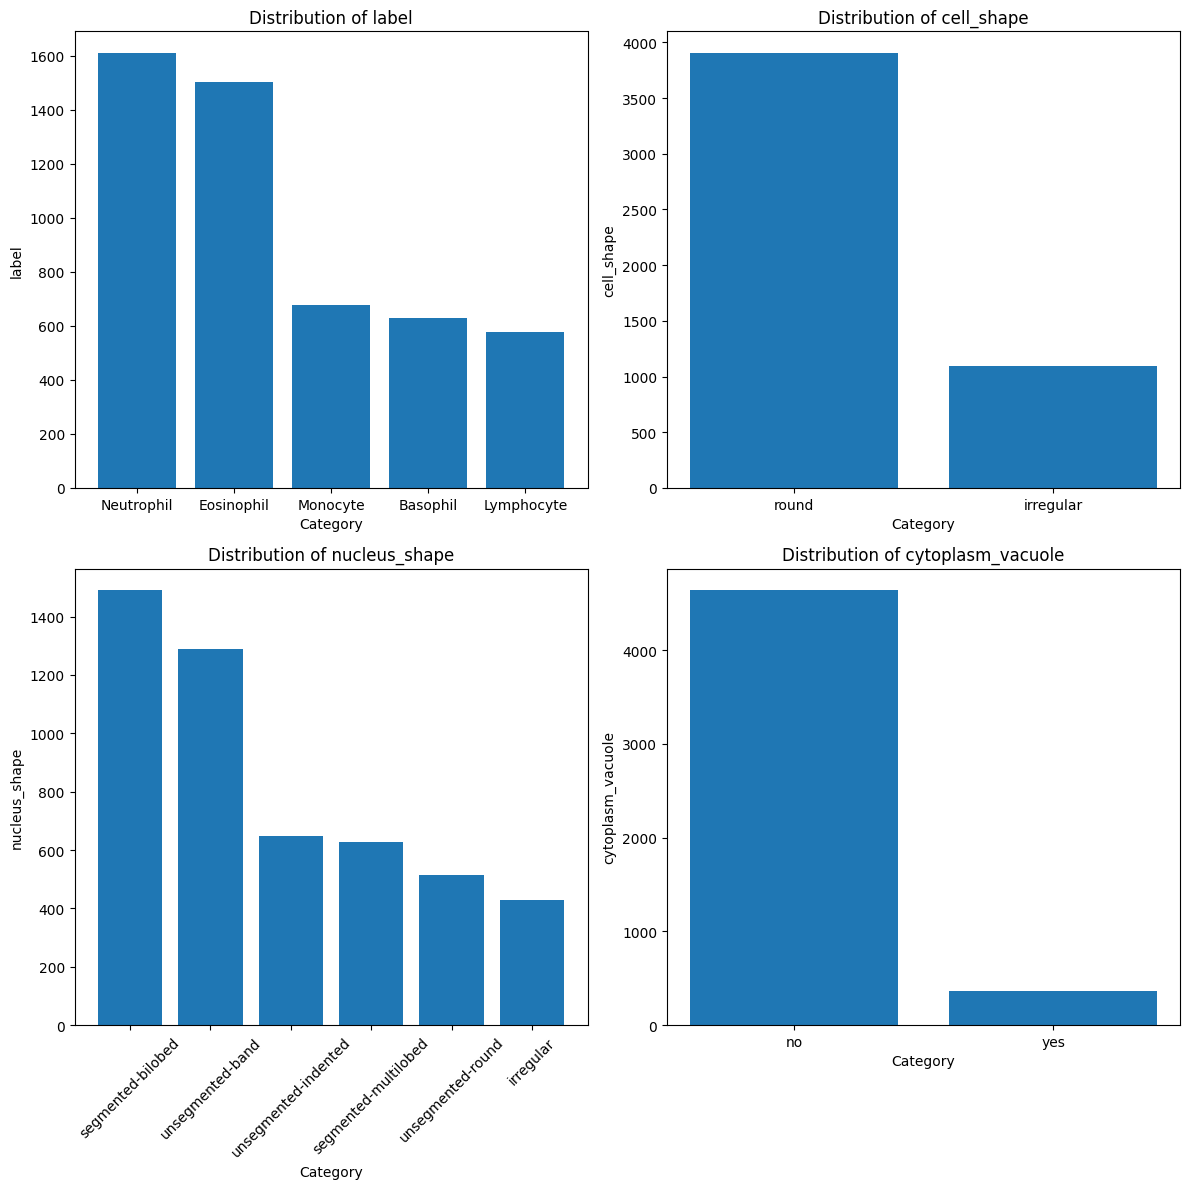

In [157]:
features = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  
axs = axs.flatten()

for i, feature in enumerate(features):
    counts = labels[feature].value_counts()
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel(feature)
    
    if feature == 'nucleus_shape':
        axs[i].set_xticklabels(counts.index, rotation = 45)

plt.tight_layout()
plt.show()

We arre dealing with imbalanced classes basically for all separate classification tasks. I would like to tackle this issue by duplicating rare label combinations which will then be augmented and therefore be different. Additionally an metric is needed that considers these imbalances. We also need to condider a combined score of all predictions.  

In [158]:
images = labels['imageID']
labels = labels.drop(columns=['imageID'])
image_names = [image + '.jpg' for image in images]

mapping_cv = {'yes':1, 'no':0}
mapping_shape = {'round':0, 'irregular':1}
mapping_type = {'Neutrophil':0, 'Eosinophil':1, 'Monocyte':2, 'Basophil':3, 'Lymphocyte':4}
mapping_nucleus = {'segmented-bilobed':1, 'unsegmented-band':2, 'unsegmented-indented':3, 'segmented-multilobed':4, 'unsegmented-round':5, 'irregular':0}

labels['label'] = labels['label'].map(mapping_type)
labels['cell_shape'] = labels['cell_shape'].map(mapping_shape)
labels['nucleus_shape'] = labels['nucleus_shape'].map(mapping_nucleus)
labels['cytoplasm_vacuole'] = labels['cytoplasm_vacuole'].map(mapping_cv)

X_train, X_val, y_train, y_val = train_test_split(image_names, labels, test_size=0.15, random_state=seed)

In [159]:
print(X_train[:5])
print(y_train.head(5))

['Img_02578.jpg', 'Img_03859.jpg', 'Img_03655.jpg', 'Img_01404.jpg', 'Img_03530.jpg']
      label  cell_shape  nucleus_shape  cytoplasm_vacuole
2577      1           0              1                  0
3858      0           0              2                  0
3654      1           0              1                  0
1403      0           0              2                  0
3529      0           0              2                  0


In [160]:
def load_image(image_filename, label):
  path = tf.strings.join([image_path, image_filename])
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image_raw, channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, image_size)

  label_shape = label[1]
  label_cv = label[3]
  label_label = tf.one_hot(label[0], 5)
  label_nucleus = tf.one_hot(label[2], 6)

  label = (label_label, label_shape, label_nucleus, label_cv)
  return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0,255]),
    tf.keras.layers.RandomZoom(height_factor=(-0.15, 0.15), width_factor=(-0.3, 0.3), fill_mode='reflect'), 
    tf.keras.layers.RandomRotation(0.2),
  ])

def augment(image_filename ,labels):
  image, labels = load_image(image_filename, labels)

  image = data_augmentation(image)
  image = preprocess_input(image)

  return image, labels

BATCH_SIZE = 64
NUM_EXAMPLES = 500
NUM_EXAMPLES_VAL = 100

train_batches = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(buffer_size=NUM_EXAMPLES)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_batches = (
  tf.data.Dataset.from_tensor_slices((X_val, y_val))
  .take(NUM_EXAMPLES_VAL)
  .cache()
  .map(load_image)
  .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
  .batch(BATCH_SIZE)
)


In [162]:
rev_type = {v:k for k,v in mapping_type.items()}
rev_shape = {v:k for k,v in mapping_shape.items()}
rev_cv = {v:k for k,v in mapping_cv.items()}
rev_nucleus = {v:k for k,v in mapping_nucleus.items()}

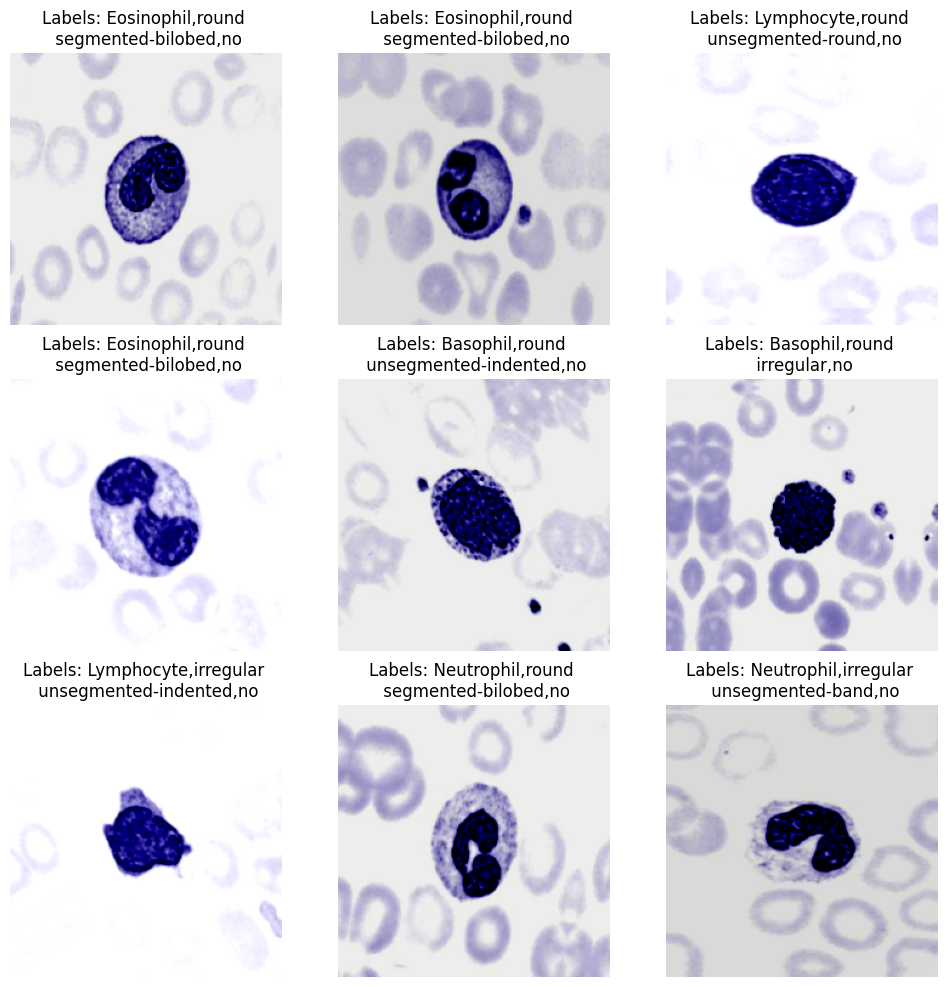

In [168]:
fig, axs = plt.subplots(3,3, figsize = (12,12))
axs = axs.flatten()

for images, labels in train_batches.take(1):    # images.shape = (batch_size, height, width, channels)
    for i in range(9):
        axs[i].imshow(images[i].numpy())
        axs[i].axis('off')
        label_type    = rev_type[tf.argmax(labels[0][i]).numpy()]
        label_shape   = rev_shape[labels[1][i].numpy()]
        label_nucleus = rev_nucleus[tf.argmax(labels[2][i]).numpy()]
        label_cv      = rev_cv[labels[3][i].numpy()]
        axs[i].set_title(f'Labels: {label_type},{label_shape} \n {label_nucleus},{label_cv}')
    break

- Do we need colour for this? 
- pretty much always in the middle of the picture. 
- There is no clear orientation - rotation, flipping can create a lot of images!

### Data augmentations to use:

- flipping! easily create more images and there is not really a correct direction random_flip_left_right(), random_flip_up_down
- Zoom - size shouldn't matter so I want to include this 
- hue random_hue()
- brightness adjusting random_brightness()
- i dont like cropping as I assume the automatic picture taking would have it in the middle usually. 



In [169]:
def model_eval_comparison(history_dict, metric='binary_cross_entropy', predictor='all'):
    fig, ax = plt.subplots()
    for name, history in history_dict.items():

        if predictor == "all":
            y_train = history.history[metric]
            y_val = history.history['val_' + metric]
            epochs = range(len(y_val))

            ax.plot(epochs, y_train, label = f'{name}_train')
            ax.plot(epochs, y_train, label = f'{name}_val')

    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(metric + 'over Epochs')
    ax.legend()

### Discussing Outputs:
- Cell type: five different classes, includes the full cell
- Cell shape: binary (round, irregular), mostly interested in the border of the cell, should be at roughly the same position. Just want to find one circle, maybe use max?  
- Nucleus Shape: Can be at an arbitrary position, definitely different sizes. Global mapping needed.
- Cytoplasm Vaculole: Can be just a few in arbitrary position, maybe max more useful? 

In [170]:
def define_model(
    base = 'ResNet50V2',
    image_size = (224,224,3),
    hlayers_activation = 'relu'
    ):
  
    if base == 'ResNet50V2':
        base_model = tf.keras.applications.ResNet50(input_shape=image_size, include_top=False, weights='imagenet')
        base_model.trainable = False
    else:
        print('ERROR')
  
    input = tf.keras.layers.Input(shape=image_size)
    x = base_model(input, training=True)
    x_max = tf.keras.layers.GlobalMaxPooling2D()(x)
    x_avg = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    #Cell type
    x_1 = tf.keras.layers.Dense(64, activation=hlayers_activation)(x_avg)
    x_1 = tf.keras.layers.BatchNormalization()(x_1)
    x_1 = tf.keras.layers.Dropout(0.25)(x_1)
    output_1 = tf.keras.layers.Dense(5, activation='softmax')(x_1)

    #Cell Shape
    x_2 = tf.keras.layers.Dense(32, activation=hlayers_activation)(x_max)
    x_2 = tf.keras.layers.BatchNormalization()(x_2)
    x_2 = tf.keras.layers.Dropout(0.25)(x_2)
    output_2 = tf.keras.layers.Dense(1, activation='sigmoid')(x_2)

    #Nucleus Shape
    x_3 = tf.keras.layers.Dense(128, activation=hlayers_activation)(x_avg)
    x_3 = tf.keras.layers.BatchNormalization()(x_3)
    x_3 = tf.keras.layers.Dropout(0.25)(x_3)
    output_3 = tf.keras.layers.Dense(6, activation='softmax')(x_3)

    #Cytoplasm Vaculole
    x_4 = tf.keras.layers.Dense(16, activation=hlayers_activation)(x_max)
    x_4 = tf.keras.layers.BatchNormalization()(x_4)
    x_4 = tf.keras.layers.Dropout(0.15)(x_4)
    output_4 = tf.keras.layers.Dense(1, activation='sigmoid')(x_4)

    model = tf.keras.models.Model(inputs=input, outputs=[output_1, output_2, output_3, output_4])
    return model

In [171]:
baseline_model = define_model()

baseline_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_21[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │    131,136 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │     65,568 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 16)        │     32,784 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_34[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 16)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 5)         │        325 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         33 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 6)         │        774 │ dropout_18[0][0]

 Total params: 24,081,581 (91.86 MB)

 Trainable params: 493,389 (1.88 MB)

 Non-trainable params: 23,588,192 (89.98 MB)

In [178]:
# ---------------------------
# Binary F1 (sigmoid outputs)
# ---------------------------
def binary_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)  # convert probabilities to 0/1
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'))
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    return 2 * (precision * recall) / (precision + recall + 1e-8)

# ---------------------------
# Multi-class F1 (softmax outputs)
# y_true: one-hot, y_pred: softmax probabilities
# ---------------------------
def multiclass_f1(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)
    
    tp = tf.cast(tf.equal(y_true_labels, y_pred_labels), 'float32')
    return tf.reduce_mean(tp)  # approximate F1 as accuracy per class

In [179]:
histories = {}

baseline_model.compile(optimizer = tf.keras.optimizers.Adam(),
        loss=[
        "categorical_crossentropy",   
        "binary_crossentropy",        
        "categorical_crossentropy",   
        "binary_crossentropy"         
        ],
        metrics=[multiclass_f1,
                 binary_f1,
                 multiclass_f1,
                 binary_f1
                 ]

)
        
        

histories['base'] = baseline_model.fit(train_batches,
                                       epochs=50,
                                       validation_data=val_batches,
                                       verbose=1,
)

Epoch 1/50
4/8 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - dense_33_loss: 0.8484 - dense_33_multiclass_f1: 0.7262 - dense_35_binary_f1: 0.2797 - dense_35_loss: 0.6825 - dense_37_loss: 1.3977 - dense_37_multiclass_f1: 0.3984 - dense_39_binary_f1: 0.0886 - dense_39_loss: 0.6740 - loss: 3.6025 

KeyboardInterrupt: 

Data Exploration: Open Dataset and explore a few example pictures. 
Data Loader: Data Augmentation,
Model Design: Read some articles, find a model to orientate by. Use pre-existing/trained model! Build fine details of what will be important. Keep FC layers small to reduce used parameters, we are looking for local structure. Test different activation functions! What is the loss function we are creating? How are we choosing the optimizer. Include Gradient clipping/ previous layer connection to avoid exploding/vanishing gradients. Try momentum. Use BAtch Normalization (remove bias before), 
Compare to simple base models, a simple CNN with maybe two hidden layers. Regularization: Data Augmentation, Dropout,?, L2, l1? 

how does the output need to look like?  Classification of bloodcell type (0-4), cell shape(round, irregular),  Cytoplasm Vacuole (y/n), nucleeus shape (0-5)

## TODO 
- Find more models to use as base? Maybe something trained on cells?
- 